# Fitting Overtones in GW150914: circular polarizations

We analyze the GW150914 ringdown using a more restrictive model than in `GW150914.ipynb` by assuming all modes are circularly polarized, corresponding to a face-off nonprecessing system. This is a special case of the "aligned" model, in which we assume the QNM initial conditions are symmetric under equatorial reflections (i.e., their excitation amplitudes satisfy $C_{\ell m n} = (-1)^\ell C_{\ell -m n}^*$), and thus the observed ellipticity of the modes depends only on the source inclination (see Appendix B in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)).

Although this more closely resembles the analysis carried out in [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), it is not meant to reproduce it exactly (e.g., it uses slightly different data, a different amplitude prior and an exponential parameterization of the Kerr deviations); the results are, nonetheless, consistent.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *

import numpyro
numpyro.set_host_device_count(4) # 4 Cores

import arviz as az
import h5py
import pandas as pd
import seaborn as sns

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

/mnt/home/wfarr/miniconda3/envs/ringdown/compiler_compat/ld: /cm/shared/sw/nix/store/aqkirva9k1vggmfcv7hy9rsy0kavh56m-gcc-10.3.0/lib64/libgfortran.so.5: undefined reference to `posix_spawn@GLIBC_2.15'
/mnt/home/wfarr/miniconda3/envs/ringdown/compiler_compat/ld: /cm/shared/sw/nix/store/aqkirva9k1vggmfcv7hy9rsy0kavh56m-gcc-10.3.0/lib64/libgfortran.so.5: undefined reference to `memcpy@GLIBC_2.14'
/mnt/home/wfarr/miniconda3/envs/ringdown/compiler_compat/ld: /cm/shared/sw/nix/store/aqkirva9k1vggmfcv7hy9rsy0kavh56m-gcc-10.3.0/lib64/libgfortran.so.5: undefined reference to `secure_getenv@GLIBC_2.17'
/mnt/home/wfarr/miniconda3/envs/ringdown/compiler_compat/ld: /cm/shared/sw/nix/store/aqkirva9k1vggmfcv7hy9rsy0kavh56m-gcc-10.3.0/lib64/libgfortran.so.5: undefined reference to `clock_gettime@GLIBC_2.17'
collect2: error: ld returned 1 exit status
/mnt/home/wfarr/miniconda3/envs/ringdown/compiler_compat/ld: /cm/shared/sw/nix/store/aqkirva9k1vggmfcv7hy9rsy0kavh56m-gcc-10.3.0/lib64/libgfortran.so.5: u

## Data

Let's download the data for GW150914, found [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/).  We grab 32s of data in each IFO, sampled at 16 kHz.

In [3]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

If you grab the data, the MD5 sums should be:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853
```

In [4]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853


Now we make timeseries data objects out of the stored data:

In [5]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')

Just a sanity-check plot of the raw strain (just look at the huuuuuge DC noise in LIGO):

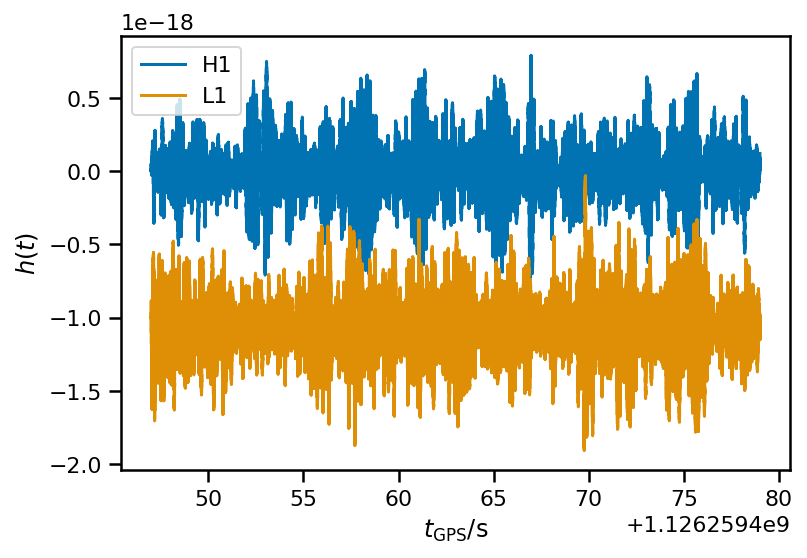

In [6]:
h_raw_strain.plot(label=h_raw_strain.ifo)
l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
ylabel(r'$h(t)$');
legend(loc='best');

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

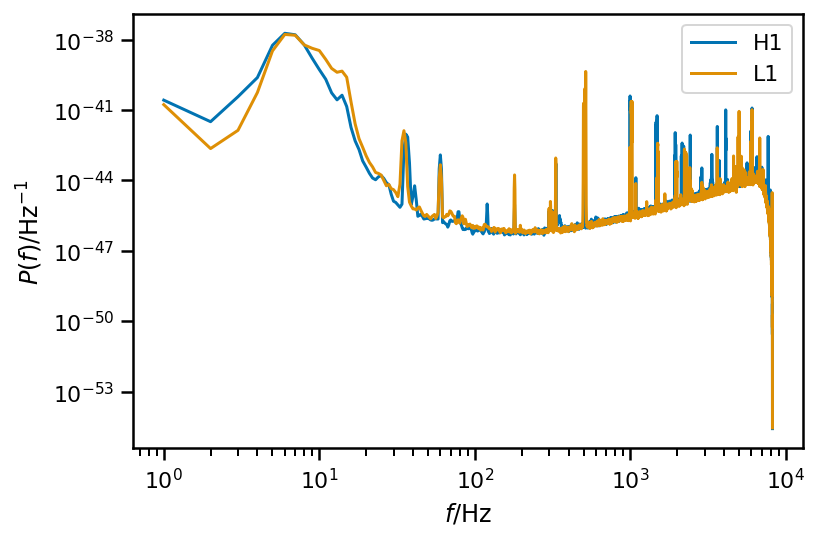

In [7]:
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a short data segment (to eliminate low frequency content)---rhe `condition_data` method below accomplishes this. We will downsample to a sample rate of 2048 Hz, and a segment length of $\sim 0.2\, \mathrm{s}$.  We choose this duration based on the impulse response of the noise whitening filter, which is of order $\sim 0.2\, \mathrm{s}$. (See `GW150914.ipynb` for further exposition.)

In [8]:
M_est = 70.0
chi_est = 0.7

longest_tau = ringdown.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/ringdown.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

T = 0.2
srate = 16384

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 200.0 ms at sample rate 16384


When we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the desired duration and sample rate, and call `condition_data`.  We high-pass filter the data with rollon at $20 \, \mathrm{Hz}$ to eliminate the large low-frequency noise present in the data.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit in this example.

Unlike in our other example, here we select the `mchi_aligned` model, which assumes the QNM excitations are symmetric under equatorial reflections, with observed ellipticity depending only on the cosine of the source inclination ($\cos \iota$).

Currently, this is only implemented for $\ell = |m| = 2$ modes: requesting a different angular harmonic will raise an error.
 The template is
$$
h_+ = \left(1+\cos^2\iota\right) \sum_n A_n e^{-t/\tau_n} \cos(\omega_n t - \phi_n)
$$
$$
h_\times = 2 \cos\iota \sum_n A_n e^{-t/\tau_n} \sin(\omega_n t - \phi_n)
$$

By construction, this is much more restrictive than our generic elliptical model (see Sec. II in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)).

In [9]:
fit = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)

It is instructive to look at the whitened data segment in both interferometers:

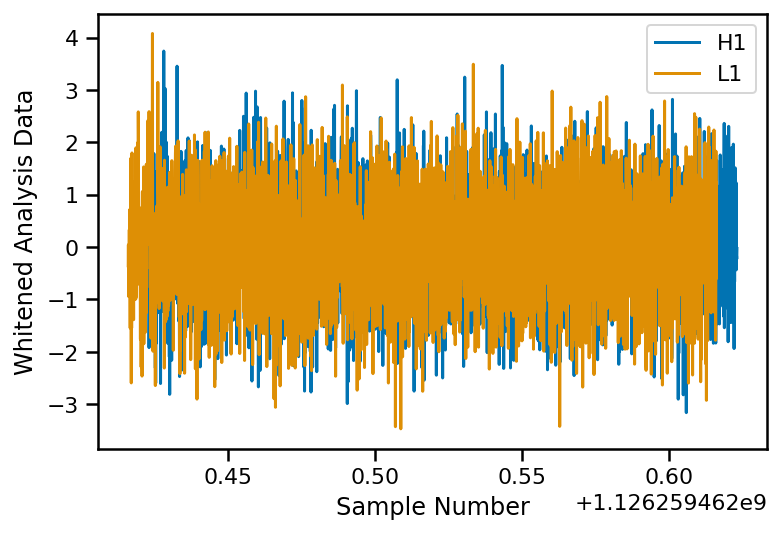

In [10]:
fit.compute_acfs()
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [11]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

## Kerr fit

Before sampling over the posterior on modes, we need to set up some priors with reasonable choices:

In [12]:
print(fit.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'cosi_min', 'cosi_max', 'flat_A']


The `flat_A` option controls whether we place a Gaussian prior on the quadratures (`flat_A = 0`, default)---which is much faster to sample because it does not have weird linear structures in the quadratures---or (as in our paper) a flat prior on `A` (`flat_A > 0`).  We set `A_scale = 5e-21`, which controls the scale of the Gaussian prior (`flat_A=0`) and also lets the sampler see approximately unit-scale variables (both prior choices).

Instead of an ellipticity parameter for each individual mode, the `mchi_aligned` model has a global inclination parameter `cosi` corresponding to the cosine of the source inclination. This parameter determines the ellipticity for _all_ modes, assuming the signal has an $\ell=|m|=2$ angular dependence and that the intrinsic mode excitations were symmetric under equatorial reflections ("nonprecessing" symmetry). By default, the prior is uniform in `-1 < cosi < 1`, but we will restrict that range by setting `cosi_max = -0.99`; this follows the expectation that the GW150914 was nearly face off.

In [13]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)

Here are the priors (with default values for the options we didn't set).  The `perturb` are boolean arrays indicating whether to perturb `f` and `tau` around the GR values; the perturbations (if present) are bounded to a maximum amplitude.

In [14]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'cosi_min': -1,
 'cosi_max': -0.99,
 'flat_A': True}

Our fit is ready to go; run it! **NOTE:** Since we picked $T = 0.2\, \mathrm{s}$ this might take a while---if you are in a hurry you can reduce that significantly (say, to $T = 0.05\, \mathrm{s}$) and still get a decent result.

(The `run()` method may take longer to execute the first time, as the model code is compiled and linked into the Python runtime.  Subsequent runs will use the precompiled code and be much quicker.)

In [ ]:
fit.run(num_chains=4)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

`fit.result` contains an arviz object giving our results:

In [26]:
az.summary(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,203.0,133.0,NaN
A[1],0.000,0.000,0.000,0.000,0.000,0.000,351.0,479.0,NaN
M,68.012,9.428,53.881,82.744,0.865,0.663,177.0,129.0,NaN
chi,0.594,0.181,0.225,0.878,0.014,0.010,164.0,130.0,NaN
f[0],241.154,8.004,226.369,255.525,0.384,0.272,466.0,461.0,NaN
f[1],234.168,9.031,218.177,250.723,0.472,0.334,382.0,475.0,NaN
tau[0],0.004,0.001,0.003,0.006,0.000,0.000,171.0,129.0,NaN
tau[1],0.001,0.000,0.001,0.002,0.000,0.000,170.0,129.0,NaN


We can plot a trace, and see visually that the sampling seems OK:

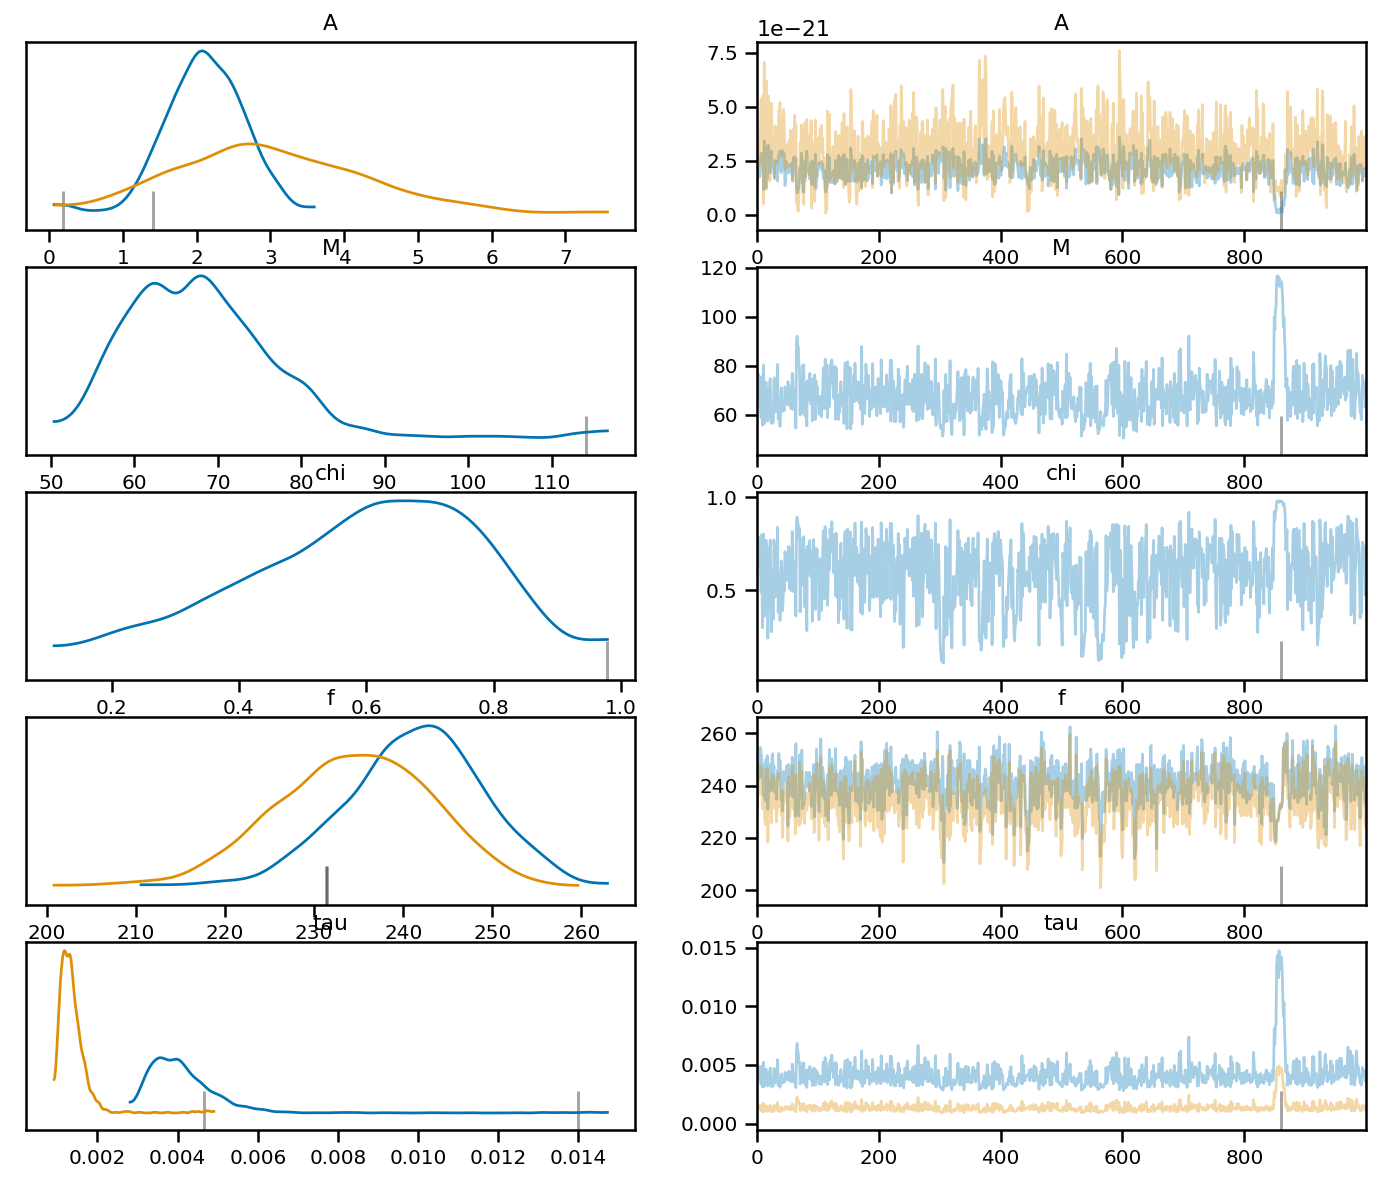

In [27]:
az.plot_trace(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'], compact=True);

In [28]:
import jax
jax.local_device_count()

1

The total mass and spin that we recover are reasonable given the full waveform analysis of GW150914 (remember that the total mass will be the *detector frame* total mass!).  Note the use of `ringdown.kdeplot_2d_clevels` which draws contours at credible levels of the KDE estimate of the posterior distribution (here at 0.9, 0.5 and 0.1 credible levels).

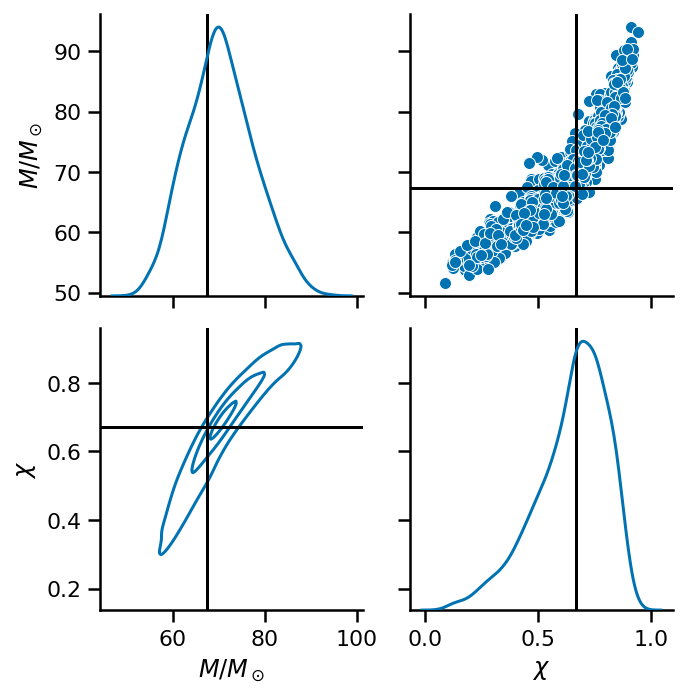

In [30]:
mIMR = 67.4
chiIMR = 0.67

df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

pg.axes[0,0].axvline(mIMR, color='k')
pg.axes[0,1].axvline(chiIMR, color='k')
pg.axes[0,1].axhline(mIMR, color='k')
pg.axes[1,0].axhline(chiIMR, color='k')
pg.axes[1,0].axvline(mIMR, color='k')
pg.axes[1,1].axvline(chiIMR, color='k')


The fundamental mode is about $240 \, \mathrm{Hz}$; we measure its frequency to better than ~5%.

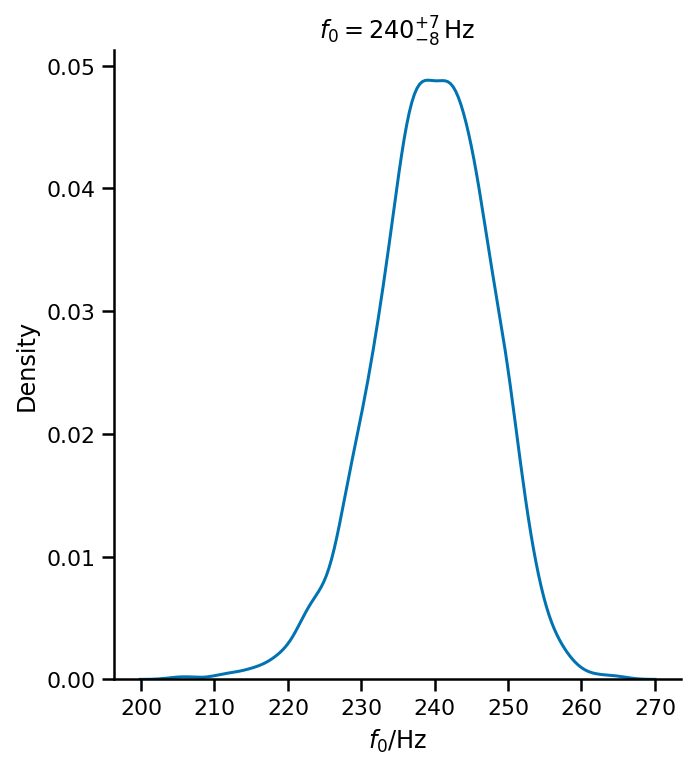

In [31]:
f0 = fit.result.posterior.f.values[:,:,0].flatten()
m = median(f0)
h = quantile(f0, 0.84)
l = quantile(f0, 0.16)
sns.displot(fit.result.posterior.f.values[:,:,0].flatten(), kind='kde')
xlabel(r'$f_0 / \mathrm{Hz}$');
title(r'$f_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{Hz}}$'.format(m, h-m, m-l));

This plot shows the 2D posterior on the amplitudes $A_0$ and $A_1$ (each of them has a flat prior due to the `flat_A=True` prior setting above).

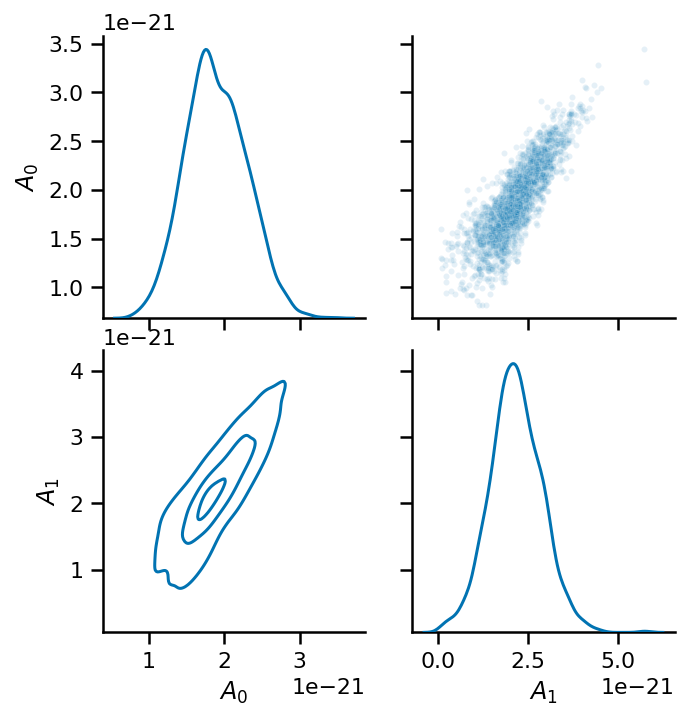

In [32]:
df = pd.DataFrame({
    r'$A_0$': fit.result.posterior.A.values[:,:,0].flatten(),
    r'$A_1$': fit.result.posterior.A.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot, alpha=0.1, marker='.');
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

It is interesting to look at the overtone amplitude:

Text(0.5, 8.95999999999998, '$A_1$')

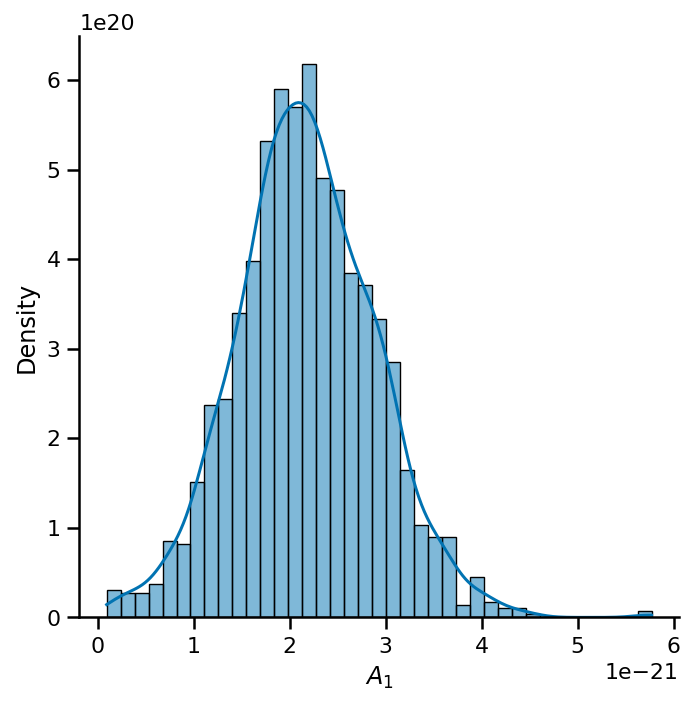

In [33]:
sns.displot(fit.result.posterior.A[:,:,1].values.flatten(), kde=True, stat='density')
xlabel(r'$A_1$')

Get median signal reconstructions at each detector:

In [34]:
ms, mf, mo = {}, {}, {}

for i, ifo in enumerate(fit.ifos):
    # median reconstructed signal at each detector
    ms[ifo] = fit.result.posterior.h_det.median(axis=(0,1)).values[i,:] 

    # median reconstructed fundamental mode at each detector
    mf[ifo] = fit.result.posterior.h_det_mode.median(axis=(0,1)).values[i,0,:]

    # median reconstructed overtone at each detector
    mo[ifo] = fit.result.posterior.h_det_mode.median(axis=(0,1)).values[i,1,:]

Here is a plot of the un-whitened (i.e. raw) ringdown signal, also decomposed into modes.

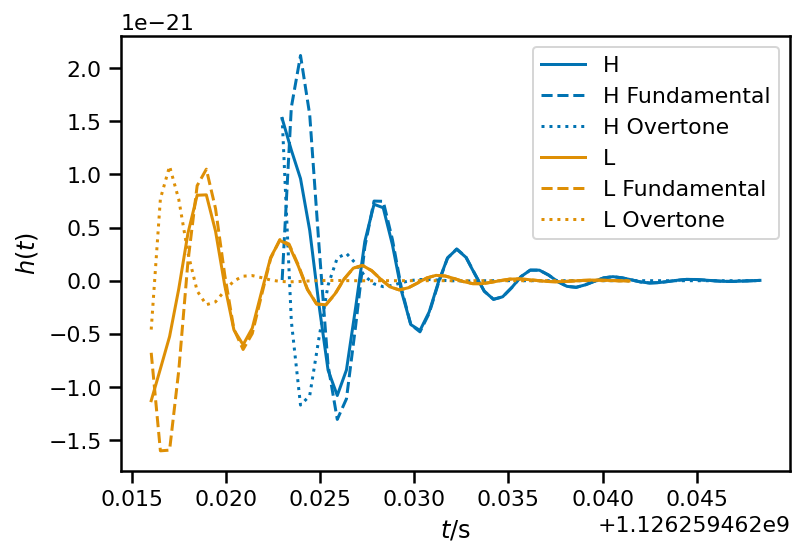

In [35]:
for ifo in fit.ifos:
    t = fit.analysis_data[ifo].time
    m = abs(t - t[0]) < 6*longest_tau
    l, = plot(t[m], ms[ifo][m], label=ifo[0])
    plot(t[m], mf[ifo][m], ls='--', color=l.get_color(), label=ifo[0]+' Fundamental')
    plot(t[m], mo[ifo][m], ls=':', color=l.get_color(), label=ifo[0]+' Overtone')

legend(loc='best');
xlabel(r'$t/\mathrm{s}$');
ylabel(r'$h(t)$');

## Beyond-Kerr fit

We can allow for perturbations to the frequency and damping rates of subsets of the ringdown modes as a spectroscopic test of GR.  First, we copy the fit object so that we are sure to use the same data, prior settings, etc, in the GR test as we did above:

In [31]:
fit_testgr = fit.copy()

A reminder about the prior options we can set:

In [32]:
print(fit_testgr.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'cosi_min', 'cosi_max', 'flat_A']


To test GR, we allow for perturbations of the overtone frequency and damping time.  The parameterization used here introduces $\delta f$ and $\delta \tau$ parameters and defines 
$$
f = f_{\mathrm{GR}} e^{\delta f}
$$
and
$$
\tau = \tau_{\mathrm{GR}} e^{\delta \tau}.
$$
Thus the perturbation is defined for all values $-\infty < \delta f, \delta \tau < \infty$ and for small values of the perturbation parameter is is the *relative* deviation of the frequency/damping time from the GR value.  By default we truncate $-1/2 < \delta f, \delta \tau < 1/2$ (corresponding to a factor of $\sqrt{e} \simeq 1.6$ change away from the GR value), but this can be changed in the prior settings as well.

In [33]:
fit_testgr.update_prior(perturb_f=[0,1], perturb_tau=[0,1])
fit_testgr.prior_settings

{'A_scale': 5e-21,
 'perturb_f': [0, 1],
 'perturb_tau': [0, 1],
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'cosi_min': -1,
 'cosi_max': -0.99,
 'flat_A': True}

In [36]:
fit_testgr.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [M, chi, cosi, Ax_unit, Ay_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, cosi, Ax_unit, Ay_unit, df, dtau]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 413 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 413 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


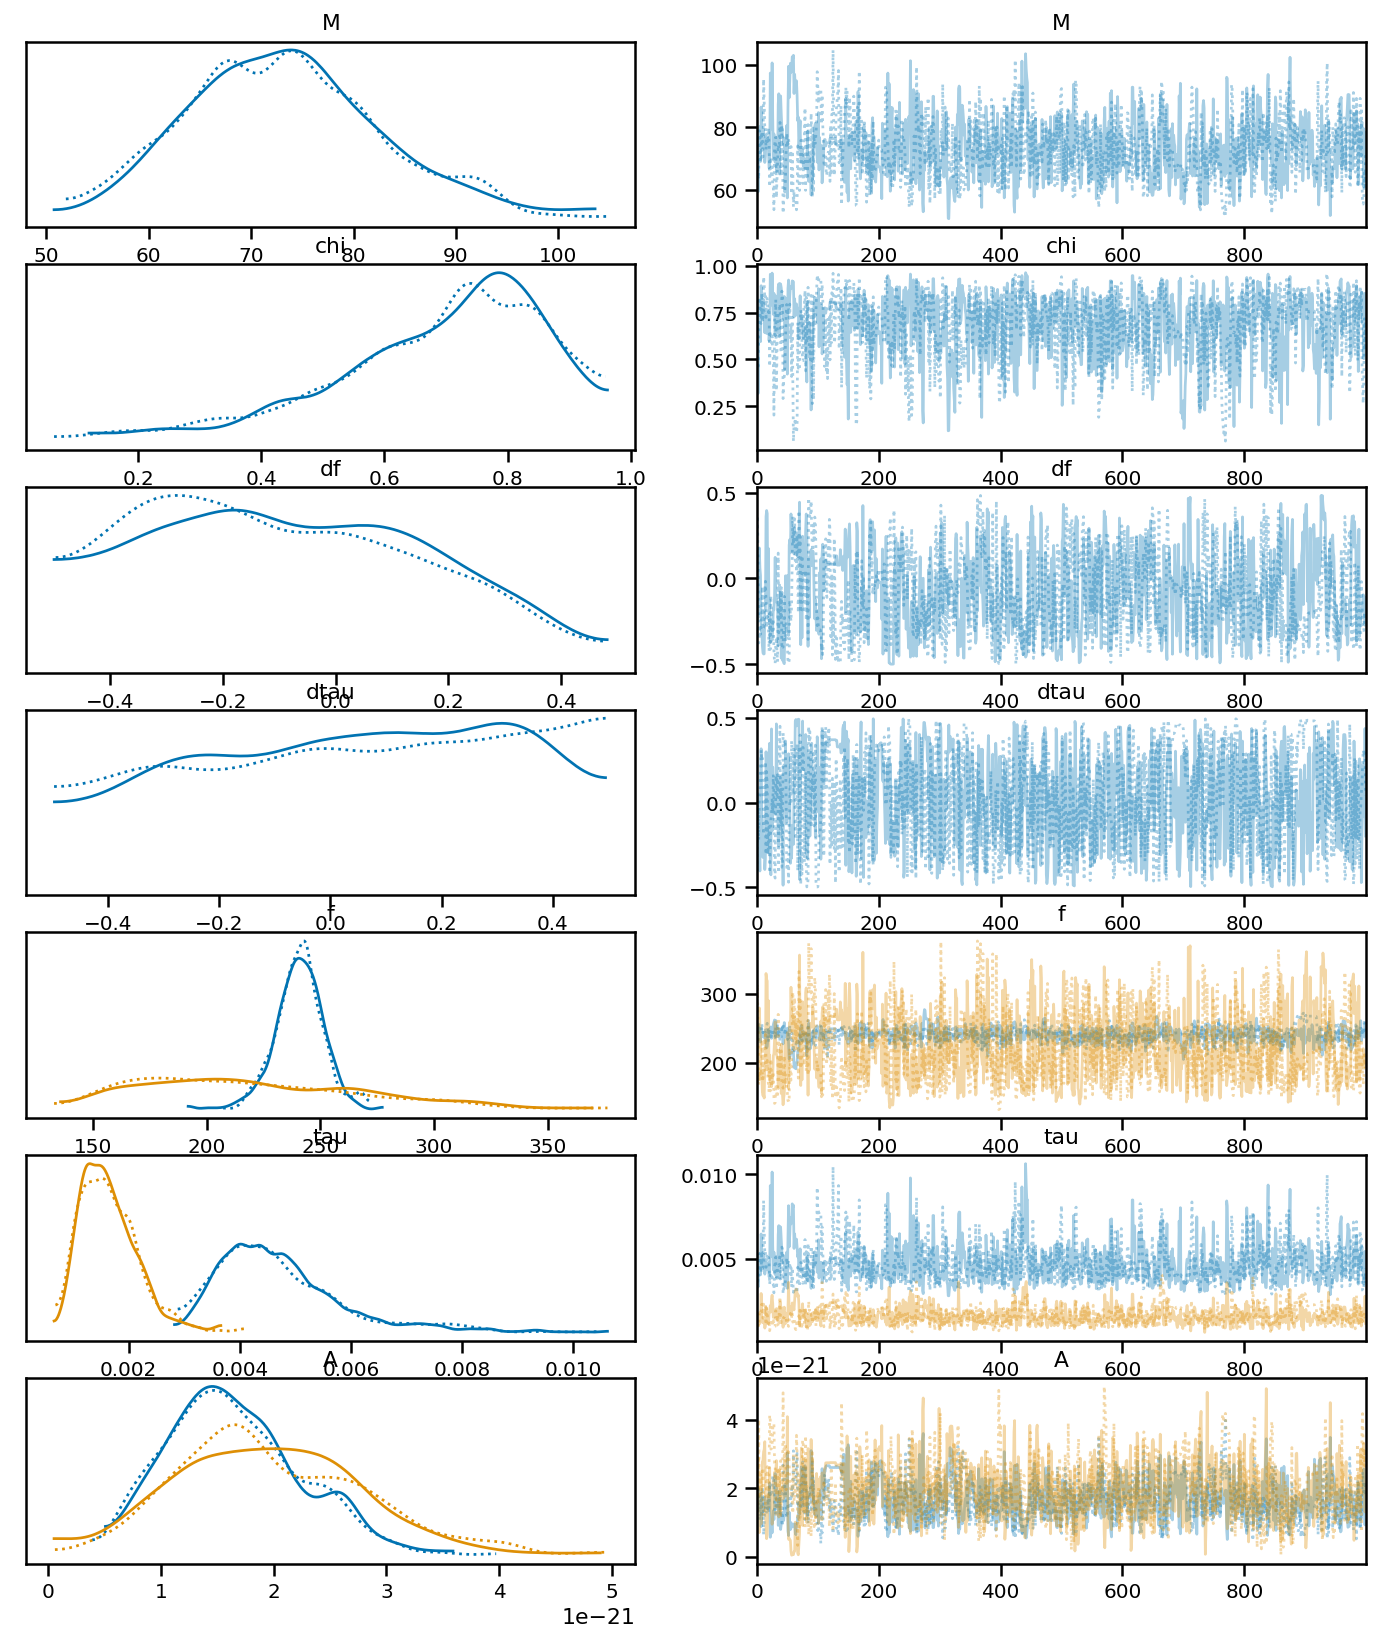

In [37]:
az.plot_trace(fit_testgr.result, var_names=['M', 'chi', 'df', 'dtau', 'f', 'tau', 'A'],
              coords={'df_dim_0': 1, 'dtau_dim_0': 1});

You can see that we place a constraint on the $\delta f$ parameter; the 1-sigma range is about 25\%, and the posterior peaks noticeably around the GR value of $\delta f = 0$.  The posterior on $\delta \tau$ is nearly flat, with a modest preference for larger $\delta \tau$, but still fully consistent with GR.  In 2D (lower left plot) the GR value of $(0,0)$ is contained within the 50% credible contour.

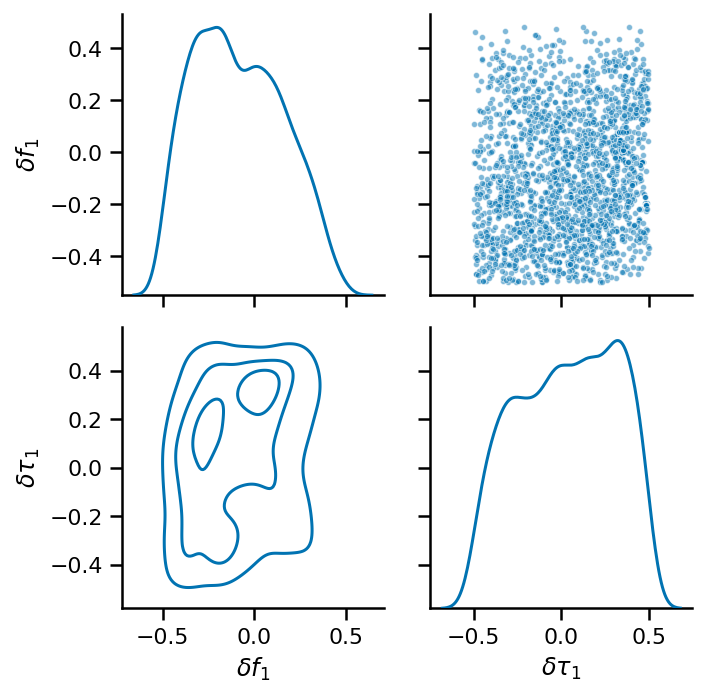

In [38]:
df = pd.DataFrame({
    r'$\delta f_1$': fit_testgr.result.posterior.df.values[:,:,1].flatten(),
    r'$\delta \tau_1$': fit_testgr.result.posterior.dtau.values[:,:,1].flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_upper(sns.scatterplot, marker='.', alpha=0.5)
pg.map_diag(sns.kdeplot)
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

In [39]:
df = fit_testgr.result.posterior.df.values[:,:,1].flatten()
print('1-sigma (68%) range of df in [{:.2f}, {:.2f}]'.format(quantile(df, 0.16), quantile(df, 0.84)))

1-sigma (68%) range of df in [-0.35, 0.18]
